In [8]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')
np.random.seed(4590)

In [27]:
PATH=Path('data/elo')

In [11]:
df_train = pd.read_csv(f'{PATH}/train.csv')
df_test = pd.read_csv(f'{PATH}/test.csv')
df_hist_trans = pd.read_csv(f'{PATH}/his_trans.csv')
df_new_merchant_trans = pd.read_csv(f'{PATH}/new_merchant_transactions.csv')

In [12]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

In [13]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [14]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

In [15]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']
df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

42

In [16]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

28

In [17]:
del df_hist_trans;gc.collect()
del df_new_merchant_trans;gc.collect()
df_train.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,...,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_card_id_size,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,9,23,35,7,...,6.0,0.260870,0.0,0.000000,23.0,-0.550160,-0.592993,54.0,2.347826,223.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,12,24,50,7,...,0.0,0.000000,0.0,0.000000,6.0,-0.550160,-0.606486,56.0,9.333333,253.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,10,14,22,7,...,1.0,1.000000,0.0,0.000000,1.0,-0.549015,-0.592993,0.0,0.000000,224.0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,6,16,20,7,...,3.0,0.428571,1.0,0.142857,7.0,-0.556518,-0.604559,41.0,5.857143,234.0
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,4,22,17,7,...,12.0,0.333333,2.0,0.055556,36.0,-0.555446,-0.588217,57.0,1.583333,224.0


In [18]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [19]:
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)

In [20]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = df_train['target']
del df_train['target']

In [21]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66706	valid_1's rmse: 3.72342
[200]	training's rmse: 3.59057	valid_1's rmse: 3.68994
[300]	training's rmse: 3.54476	valid_1's rmse: 3.67666
[400]	training's rmse: 3.50846	valid_1's rmse: 3.66857
[500]	training's rmse: 3.47943	valid_1's rmse: 3.66328
[600]	training's rmse: 3.45434	valid_1's rmse: 3.66033
[700]	training's rmse: 3.43089	valid_1's rmse: 3.65802
[800]	training's rmse: 3.41002	valid_1's rmse: 3.65614
[900]	training's rmse: 3.39064	valid_1's rmse: 3.6548
[1000]	training's rmse: 3.37273	valid_1's rmse: 3.6545
[1100]	training's rmse: 3.35645	valid_1's rmse: 3.65396
[1200]	training's rmse: 3.34135	valid_1's rmse: 3.65405
Early stopping, best iteration is:
[1179]	training's rmse: 3.34491	valid_1's rmse: 3.65391
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66815	valid_1's rmse: 3.71506
[200]	training's rmse: 3.59189	valid_1's rmse: 3.6834

3.6533775872161125

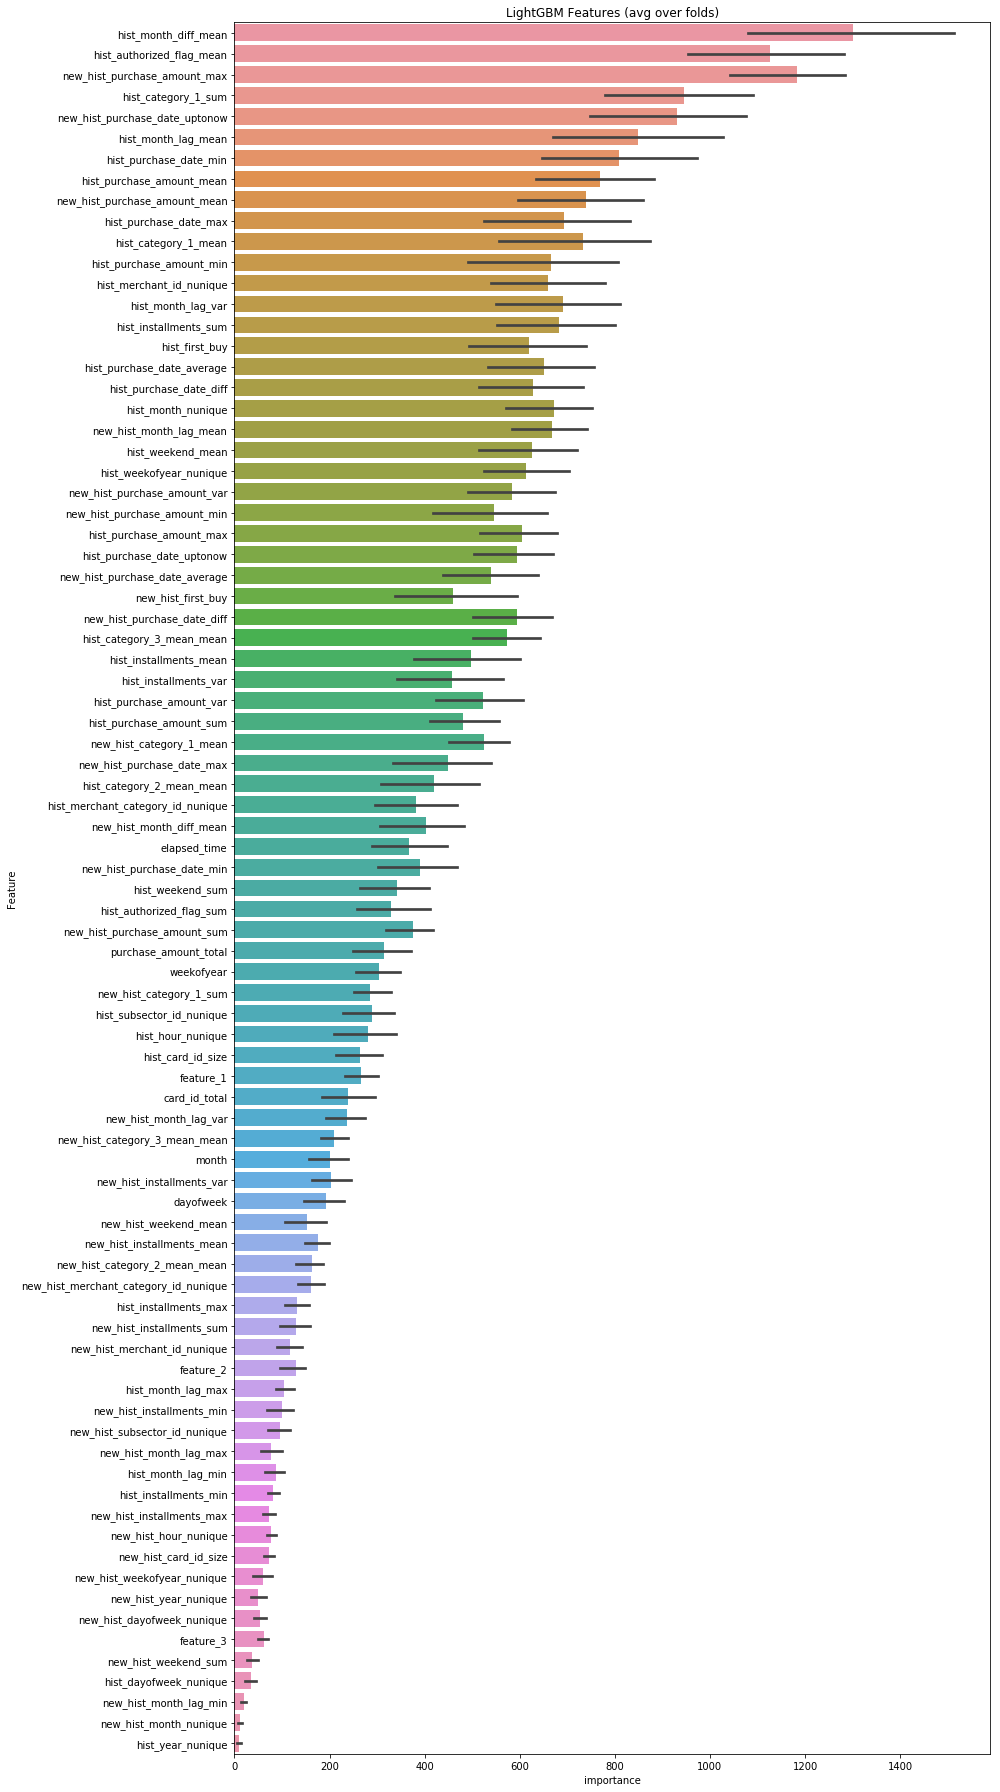

In [22]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [23]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv(f'{PATH}\submissionv4.csv', index=False)

In [29]:
df_train.to_csv('trainv4.csv', index=False)
df_test.to_csv('testv4.csv', index=False)

In [30]:
df_train.columns

Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'hist_month_nunique', 'hist_hour_nunique', 'hist_weekofyear_nunique',
       'hist_dayofweek_nunique', 'hist_year_nunique',
       'hist_subsector_id_nunique', 'hist_merchant_id_nunique',
       'hist_merchant_category_id_nunique', 'hist_purchase_amount_sum',
       'hist_purchase_amount_max', 'hist_purchase_amount_min',
       'hist_purchase_amount_mean', 'hist_purchase_amount_var',
       'hist_installments_sum', 'hist_installments_max',
       'hist_installments_min', 'hist_installments_mean',
       'hist_installments_var', 'hist_purchase_date_max',
       'hist_purchase_date_min', 'hist_month_lag_max', 'hist_month_lag_min',
       'hist_month_lag_mean', 'hist_month_lag_var', 'hist_month_diff_mean',
       'hist_authorized_flag_sum', 'hist_authorized_flag_mean',
       'hist_weekend_sum', 'hist_weekend_mean', 'hist_category_1_sum',
       'hist_category_1_mean', 'hist_card_id_size',
       'hist_c

In [53]:
features =['card_id_total',
       'purchase_amount_total','hist_purchase_amount_sum',
       'hist_purchase_amount_max', 'hist_purchase_amount_min',
       'hist_purchase_amount_mean', 'hist_purchase_amount_var',
       'hist_installments_sum', 'hist_installments_max',
       'hist_installments_min', 'hist_installments_mean',
       'hist_installments_var']
categorical_feats=['first_active_month','feature_1', 'feature_2', 'feature_3',
       'hist_month_nunique', 'hist_hour_nunique', 'hist_weekofyear_nunique',
       'hist_dayofweek_nunique', 'hist_year_nunique',
       'hist_subsector_id_nunique', 'hist_merchant_id_nunique',
       'hist_merchant_category_id_nunique',  'new_hist_month_nunique',
       'new_hist_hour_nunique', 'new_hist_weekofyear_nunique',
       'new_hist_dayofweek_nunique', 'new_hist_year_nunique',
       'new_hist_subsector_id_nunique', 'new_hist_merchant_id_nunique',
       'new_hist_merchant_category_id_nunique','dayofweek', 'weekofyear', 'month', 'elapsed_time',
       'hist_first_buy', 'new_hist_first_buy']

In [34]:
df_train['target'] = target 

In [54]:
dep = 'target'
df_train1 = df_train[categorical_feats+features+[dep]].copy()

In [55]:
df_test[dep] = 0.0
df_test1 = df_test[categorical_feats+features+[dep, 'card_id']].copy()

In [56]:
from fastai.learner import *
from fastai.column_data import *
from fastai.structured import *

In [57]:
for v in categorical_feats: df_train1[v] = df_train1[v].astype('category').cat.as_ordered()
apply_cats(df_test1, df_train1)

In [58]:
for v in features:
    df_train1[v] = df_train1[v].fillna(0).astype('float32')
    df_test1[v] = df_test1[v].fillna(0).astype('float32')

In [59]:
samp_size = len(df_train1)
df, y, nas, mapper = proc_df(df_train1, dep, do_scale=True)

In [60]:
df_test2, _, nas, mapper = proc_df(df_test1, dep, do_scale=True,skip_flds=['card_id'],mapper=mapper, na_dict=nas)

In [61]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

In [62]:
def exp_rmse(y_pred, targ):
#     targ = inv_y(targ)
    pct_var = (targ - y_pred)
    return math.sqrt((pct_var**2).mean())

y_range = (0, 1)

In [63]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype(np.float32), cat_flds=categorical_feats, bs=128,
                                       test_df=df_test2)

In [64]:
cat_sz = [(c, len(df_train1[c].cat.categories)+1) for c in categorical_feats]
cat_sz

[('first_active_month', 76),
 ('feature_1', 6),
 ('feature_2', 4),
 ('feature_3', 3),
 ('hist_month_nunique', 12),
 ('hist_hour_nunique', 25),
 ('hist_weekofyear_nunique', 53),
 ('hist_dayofweek_nunique', 8),
 ('hist_year_nunique', 3),
 ('hist_subsector_id_nunique', 35),
 ('hist_merchant_id_nunique', 314),
 ('hist_merchant_category_id_nunique', 93),
 ('new_hist_month_nunique', 3),
 ('new_hist_hour_nunique', 24),
 ('new_hist_weekofyear_nunique', 11),
 ('new_hist_dayofweek_nunique', 8),
 ('new_hist_year_nunique', 3),
 ('new_hist_subsector_id_nunique', 25),
 ('new_hist_merchant_id_nunique', 87),
 ('new_hist_merchant_category_id_nunique', 40),
 ('dayofweek', 8),
 ('weekofyear', 22),
 ('month', 13),
 ('elapsed_time', 76),
 ('hist_first_buy', 1906),
 ('new_hist_first_buy', 1899)]

In [67]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(76, 38),
 (6, 3),
 (4, 2),
 (3, 2),
 (12, 6),
 (25, 13),
 (53, 27),
 (8, 4),
 (3, 2),
 (35, 18),
 (314, 50),
 (93, 47),
 (3, 2),
 (24, 12),
 (11, 6),
 (8, 4),
 (3, 2),
 (25, 13),
 (87, 44),
 (40, 20),
 (8, 4),
 (22, 11),
 (13, 7),
 (76, 38),
 (1906, 50),
 (1899, 50)]

In [68]:
m = md.get_learner(emb_szs,len(df.columns)-len(categorical_feats),0.04,1,[1000,500],[0.001,0.01])

 61%|█████████████████████████████████████████▍                          | 722/1184 [00:17<00:10, 42.20it/s, loss=64.3]

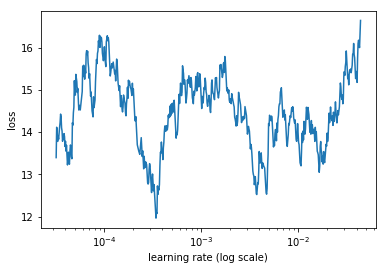

 61%|█████████████████████████████████████████▍                          | 722/1184 [00:30<00:19, 24.06it/s, loss=64.3]

In [69]:
lr=1e-5
m.lr_find()
m.sched.plot(100)

In [70]:
lr=1e-4
m = md.get_learner(emb_szs, len(df.columns)-len(categorical_feats),
                   0.04, 1, [1000,500], [0.001,0.01])


In [72]:
m.fit(lr, 10,metrics=[exp_rmse],cycle_len=1)

epoch      trn_loss   val_loss   exp_rmse                                                                              
    0      11.840207  14.879795  3.772714  
    1      13.104951  14.885957  3.774225                                                                              
    2      13.143382  14.895667  3.776221                                                                              
    3      13.069163  14.974397  3.787877                                                                              
    4      11.7556    15.048848  3.798768                                                                              
 47%|███████████████████████████████▋                                    | 552/1184 [00:12<00:14, 44.50it/s, loss=11.3]

KeyboardInterrupt: 

 47%|███████████████████████████████▋                                    | 552/1184 [00:30<00:34, 18.40it/s, loss=11.3]